## Impute genes for MERFISH


In [1]:
import uniport as up
import scanpy as sc
import numpy as np
from scipy.stats import spearmanr, pearsonr
import pandas as pd
from scvi.external import GIMVI
print(up.__version__)

seed = 1
train_size = 0.8
np.random.seed(seed)

Global seed set to 0


1.1.2


/home/kcao/miniconda3/envs/py39/lib/python3.9/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/home/kcao/miniconda3/envs/py39/lib/python3.9/site-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_experiment` instead.
  return new_rank_zero_deprecation(*args, **kwargs)


Read and process data.

In [2]:
labels_merfish = pd.read_csv('/home/kcao/uniPort/MERFISH/MERFISH_mouse1_cluster.txt', sep='\t')
celltype_merfish = labels_merfish['cluster_main'].values
labels_rna = pd.read_csv('/home/kcao/uniPort/MERFISH/scRNA_cluster.txt', sep='\t')
celltype_rna = labels_rna['cluster_main'].values

spatial_data = sc.read_h5ad('/home/kcao/uniPort/MERFISH/merfish0.h5ad')
seq_data = sc.read_h5ad('/home/kcao/uniPort/MERFISH/rna0.h5ad')

spatial_data.obs['cell_type'] = celltype_merfish
spatial_data.obs['domain_id'] = 0
spatial_data.obs['domain_id'] = spatial_data.obs['domain_id'].astype('category')
spatial_data.obs['source'] = 'MERFISH'

seq_data.obs['cell_type'] = celltype_rna
seq_data.obs['domain_id'] = 1
seq_data.obs['domain_id'] = seq_data.obs['domain_id'].astype('category')
seq_data.obs['source'] = 'RNA'

adata_cm = spatial_data.concatenate(seq_data, join='inner', batch_key='domain_id')
spatial_data = adata_cm[adata_cm.obs['source']=='MERFISH'].copy()
seq_data = adata_cm[adata_cm.obs['source']=='RNA'].copy()

Randomly select training and testing genes.

In [3]:
#only use genes in both datasets
seq_data = seq_data[:, spatial_data.var_names].copy()

seq_gene_names = seq_data.var_names
n_genes = seq_data.n_vars
n_train_genes = int(n_genes*train_size)

#randomly select training_genes
rand_train_gene_idx = np.random.choice(range(n_genes), n_train_genes, replace = False)
rand_test_gene_idx = sorted(set(range(n_genes)) - set(rand_train_gene_idx))
rand_train_genes = seq_gene_names[rand_train_gene_idx]
rand_test_genes = seq_gene_names[rand_test_gene_idx]

#spatial_data_partial has a subset of the genes to train on
spatial_data_partial = spatial_data[:,rand_train_genes].copy()

#remove cells with no counts
sc.pp.filter_cells(spatial_data_partial, min_counts= 1)
sc.pp.filter_cells(seq_data, min_counts = 1)

#setup_anndata for spatial and sequencing data
GIMVI.setup_anndata(spatial_data_partial, labels_key='cell_type', batch_key='source')
GIMVI.setup_anndata(seq_data, labels_key='cell_type')

#spatial_data should use the same cells as our training data
#cells may have been removed by scanpy.pp.filter_cells()
spatial_data = spatial_data[spatial_data_partial.obs_names]

print(spatial_data_partial.var_names)

Index(['Htr2c', 'Cyp19a1', 'Man1a', 'Tiparp', 'Cspg5', 'Sema4d', 'Pou3f2',
       'Cbln1', 'Gem', 'Fn1',
       ...
       'Trhr', 'Galr1', 'Cenpe', 'Mc4r', 'Amigo2', 'Sst', 'Crhr2', 'Trh',
       'Sema3c', 'Gabrg1'],
      dtype='object', length=122)


In [4]:
adata_cm = spatial_data_partial.concatenate(seq_data, join='inner', batch_key='domain_id')

In [5]:
sc.pp.normalize_total(adata_cm)
sc.pp.log1p(adata_cm)
up.batch_scale(adata_cm)
print(adata_cm)

AnnData object with n_obs × n_vars = 94741 × 122
    obs: 'cell_type', 'domain_id', 'source', 'n_counts', '_scvi_batch', '_scvi_labels'
    uns: 'log1p'


In [6]:
sc.pp.normalize_total(spatial_data_partial)
sc.pp.log1p(spatial_data_partial)
up.batch_scale(spatial_data_partial)
print(spatial_data_partial)

AnnData object with n_obs × n_vars = 64373 × 122
    obs: 'cell_type', 'domain_id', 'source', 'n_counts', '_scvi_batch', '_scvi_labels'
    uns: '_scvi_uuid', '_scvi_manager_uuid', 'log1p'


In [7]:
sc.pp.normalize_total(seq_data)
sc.pp.log1p(seq_data)
up.batch_scale(seq_data)
print(seq_data)

AnnData object with n_obs × n_vars = 30368 × 153
    obs: 'cell_type', 'domain_id', 'source', 'n_counts', '_scvi_batch', '_scvi_labels'
    uns: '_scvi_uuid', '_scvi_manager_uuid', 'log1p'


In [8]:
adatas = [spatial_data_partial, seq_data]

Integrate the MERFISH and scRNA-seq data using both common and dataset-specific genes by `Run()` function in uniport. The latent representations of data are stored in `adata.obs['latent']`.

In [9]:
adata = up.Run(adatas=adatas, adata_cm=adata_cm, lambda_kl=5.0, model_info=True)

Device: cuda
Dataset 0: MERFISH
AnnData object with n_obs × n_vars = 64373 × 122
    obs: 'cell_type', 'domain_id', 'source', 'n_counts', '_scvi_batch', '_scvi_labels'
    uns: '_scvi_uuid', '_scvi_manager_uuid', 'log1p'
Dataset 1: RNA
AnnData object with n_obs × n_vars = 30368 × 153
    obs: 'cell_type', 'domain_id', 'source', 'n_counts', '_scvi_batch', '_scvi_labels'
    uns: '_scvi_uuid', '_scvi_manager_uuid', 'log1p'
Reference dataset is dataset 1


Data with common HVG
AnnData object with n_obs × n_vars = 94741 × 122
    obs: 'cell_type', 'domain_id', 'source', 'n_counts', '_scvi_batch', '_scvi_labels'
    uns: 'log1p'




INFO:root:model
VAE(
  (encoder): Encoder(
    (enc): ModuleList(
      (0): NN(
        (net): ModuleList(
          (0): Block(
            (fc): Linear(in_features=122, out_features=1024, bias=True)
            (norm): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (act): ReLU()
          )
        )
      )
    )
    (mu_enc): ModuleList(
      (0): NN(
        (net): ModuleList(
          (0): Block(
            (fc): Linear(in_features=1024, out_features=16, bias=True)
          )
        )
      )
    )
    (var_enc): ModuleList(
      (0): NN(
        (net): ModuleList(
          (0): Block(
            (fc): Linear(in_features=1024, out_features=16, bias=True)
          )
        )
      )
    )
  )
  (decoder): Decoder(
    (dec): ModuleList(
      (0): NN(
        (net): ModuleList(
          (0): Block(
            (fc): Linear(in_features=16, out_features=122, bias=True)
            (norm): DSBatchNorm(
              (bns): Mo

Predict 

In [10]:
adata_predict = up.Run(adata_cm=spatial_data_partial, out='predict', pred_id=1)
print(np.shape(adata_predict.obsm['predict']))

Device: cuda
(64373, 153)


... storing 'cell_type' as categorical
... storing 'source' as categorical


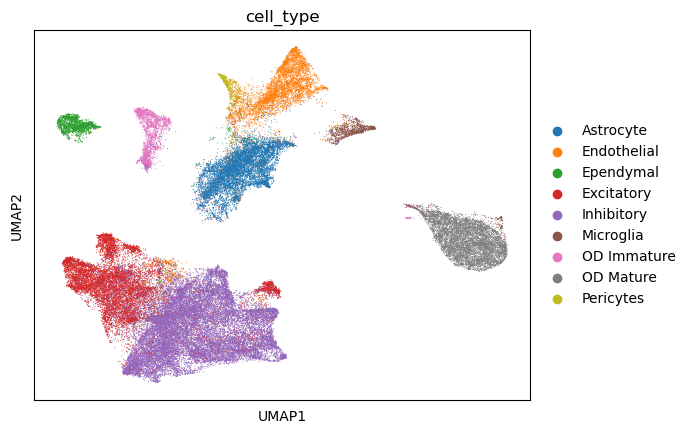

In [11]:
sc.pp.neighbors(adata_predict, use_rep='predict')
sc.tl.umap(adata_predict, min_dist=0.1)
sc.pl.umap(adata_predict, color=['cell_type'])

Compute average/median Spearman and Pearson Correlation Coefficients. 

In [12]:
def imputation_score(fish_imputation, data_spatial, gene_ids_test, normalized=True):
#     _, fish_imputation = model.get_imputed_values(normalized=normalized)
    original, imputed = (
        data_spatial.X[:, gene_ids_test],
        fish_imputation[:, gene_ids_test],
    )

    if normalized:
        original /= data_spatial.X.sum(axis=1).reshape(-1, 1)
        
    original = np.array(original)
        
    spearman_gene = []
    pearsonr_gene = []
    for g in range(imputed.shape[1]):
        if np.all(imputed[:, g] == 0):
            correlation_scc = 0
            correlation_pcc=0
        else:
            correlation_scc = spearmanr(original[:, g], imputed[:, g])[0]
            correlation_pcc = pearsonr(original[:, g], imputed[:, g])[0]
        spearman_gene.append(correlation_scc)
        pearsonr_gene.append(correlation_pcc)
    return np.median(np.array(spearman_gene)), np.mean(np.array(spearman_gene)), np.median(np.array(pearsonr_gene)), np.mean(np.array(pearsonr_gene)), 

print(imputation_score(adata_predict.obsm['predict'], spatial_data, rand_test_gene_idx, True))

(0.26249964194121306, 0.2639037051584925, 0.2721606922755887, 0.2920161196211757)
